### loading and cleaning

In [70]:
import matplotlib 
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from __future__ import print_function
from time import time
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
n_samples = 2000
n_features = 10000
n_topics = 10
n_top_words = 20

In [11]:
MyFile = r"C:\Users\Bill\Desktop\Tahzoo.com Redesign\GoogleAnalytics\Experiments\labels_categories_actions.tsv"
d1 = pd.read_csv(MyFile, sep="\t")
d1.head()

,eventLabel,eventCategory,users
1,GA1.2.1000767845.1461767781,::ABOUT,1
2,GA1.2.1000767845.1461767781,column twelve::BRAD HEIDEMANN Chief Executive ...,1
3,GA1.2.1001075852.1456520683,::Clients,1
4,GA1.2.1001075852.1456520683,slick-next::Next,1
5,GA1.2.1001361534.1458136980,::ABOUT,1


In [12]:
d1 = d1[d1['eventLabel'].apply(lambda x: "GA1." in x)] 

Using individual events to infer a ‘topicality’ is similar to the assumptions in TOPIC MODELING: Assuming that an inherent theme in the user's behavior can be derived from the individual actions (.
I've constructed a corpus as a list of events. So you can see here that this person clicked on "JOIN", "READ MORE" and "BUSINESS OPERATIONS ANALYST AVAILABLE IN:". Those are a "Bag-of-events" lists that will be used to build the Personas. 

In [88]:
corpus = {}
for i in np.unique(d1['eventLabel']):       #very long cleaning syntax :(
    context = "::".join(d1[d1.eventLabel == i].eventCategory.tolist())
    for word in bad_words:
        context = context.replace(word," ")
    cleaned_context = "".join([word for word in context.split(" ") if len(word)>1]).replace("::"," ")
    corpus[i] = cleaned_context

In [89]:
len(corpus)

4678

In [90]:
corpus.keys()[1]

'GA1.2.905673169.1463358214'

Because the LDA model is traditionally used to find "topics" in text documents, I'm joining the text like so in order to create a " " separated list of tokens. 

In [91]:
corpus[corpus.keys()[1]]

' JOIN  READMORE jg--p BUSINESSOPERATIONSANALYSTAVAILABLEIN  :'

In [92]:
corpus.keys()[35]

'GA1.2.1560718834.1466087667'

In [93]:
corpus[corpus.keys()[35]]

' ABOUT  '

Note that I’m using the inner HTML and class of the DOM element. In the current Tahzoo.com site the DOM elements have unspecific or unclear names. Inner HTML was substituted because it gives us some sense of what the user actually clicked on. 
* Better labels in DOM elements would make better models
* Other kinds of events (hover, scroll, backup, etc.) would also be useful

These are not implemented here as this is merely a POC.


### This is the part where we build the actual model

In [94]:
data_samples = corpus.values()
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features,
                                stop_words='english')

tf = tf_vectorizer.fit_transform(data_samples)

In [95]:
print("Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online', learning_offset=50.,
                                random_state=0)
lda.fit(tf)
tf_feature_names = tf_vectorizer.get_feature_names()

Fitting LDA models with tf features, n_samples=2000 and n_features=10000...


In [96]:
#bunch of functions that I wrote to build the tables for the model:
def get_single_topic(lda, tf_feature_names, n_top_words, topic):
    words = [tf_feature_names[i] for i in lda.components_[topic].argsort()[:-n_top_words - 1:-1]]
    scores = lda.components_[topic][lda.components_[topic].argsort()[:-n_top_words - 1:-1]]
    df = pd.DataFrame(index=words,columns=['topic_{}'.format(topic)],data=scores)
    return df

def get_all_topics(lda, tf_feature_names, n_top_words,n_topics):
    df = pd.DataFrame()
    for topic in range(n_topics):
        tmpdf = get_single_topic(lda, tf_feature_names, n_top_words, topic)
        for item in tmpdf.index:
            df.loc[item,'topic_{}'.format(topic)] = tmpdf.loc[item,'topic_{}'.format(topic)]
    return df

def get_topic_names(lda, tf_feature_names, n_top_words, n_topics):
    themes = pd.Series()
    for topic in range(n_topics):
        theme = " ".join([tf_feature_names[i] for i in lda.components_[topic].argsort()[:-n_top_words - 1:-1]])
        themes.loc['topic_{}'.format(topic)] = theme
    return themes

df = get_all_topics(lda, tf_feature_names, n_top_words,n_topics)

In [97]:
df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
join,197.903973,NaN,232.099814,125.193919,NaN,121.807906,NaN,NaN,NaN,NaN
readmore,60.116589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seattlerihmonddelft,43.038291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pg,33.003440,NaN,NaN,NaN,NaN,40.883459,NaN,NaN,NaN,NaN
webdeveloperavailablein,31.705257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
def score_document(doc_dic,df,lda, tf_feature_names, n_top_words, n_topics,
                    returnDF=True,confidence=.01):
    '''
    gives scores to the origional document, assigning a category to each one. 

    returnDF : By default returns a DataFrame, set to false to return a dict.
    confidence : this is the threashold that the model must meet to match the document to a topic.
    set to .01 to include practically everything, set to .99 to include almost nothing.


    document_scores = score_document(doc_dic,df,lda, tf_feature_names, n_top_words, n_topics)
    '''
    results_dict = {}
    for key in doc_dic.keys():
        document = doc_dic[key]
        words = [tf_feature_names[i] for i in tf.getrow(doc_dic.keys().index(key)).indices]
        scores = df[[word in words for word in df.index]]
        TM_Score = pd.DataFrame()
        TM_Score['docScore'] = scores.sum() 
        TM_Score['globalScore'] = df.sum()
        TM_Score['relevance'] = TM_Score['docScore']/TM_Score['globalScore']
        TM_Score['theme'] = get_topic_names(lda, tf_feature_names, n_top_words, n_topics)
        results = TM_Score['relevance'].fillna(0).to_dict()
        results['document'] = document
        results['top_score'] = TM_Score['relevance'].max()

        if TM_Score['relevance'].max() >= confidence:
            results['top_theme'] = TM_Score['theme'][TM_Score['relevance'].tolist().index(TM_Score['relevance'].max())]
            results['top_topic'] = TM_Score.index[TM_Score['relevance'].tolist().index(TM_Score['relevance'].max())]
        else: 
            results['top_theme'] = 'unassigned'
            results['top_topic'] = 'unassigned'
        results_dict[key] = results
    if returnDF:
        return pd.DataFrame(results_dict).T
    else:
        return results_dict

    
Scored_corpus = score_document(corpus,df,lda, tf_feature_names, n_top_words, n_topics)

In [67]:
Scored_corpus.head()

,document,top_score,top_theme,top_topic,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
GA1.2.1000767845.1461767781,ABOUT BRAD HEIDEMANN Ex iv Offic,0.659162,brad heidemann offic iv ex hi ip vic hendriks ...,topic_0,0.659162,0,0,0.0345026,0.15588,0,0,0.0881421,0,0.0344578
GA1.2.1001075852.1456520683,ick-,0.052918,servi es lients join news ick business exe dev...,topic_5,0,0,0.0417342,0,0.043319,0.052918,0,0,0,0
GA1.2.1001361534.1458136980,ABOUT __i m__ __i m__ vi __i m__ ck ic,0.498616,__i m__ __ ic va wa mi ip uk iv vi ric onta nl...,topic_9,0,0,0.126666,0.115372,0.111922,0,0.0788973,0.217295,0,0.498616
GA1.2.1001524715.1453749442,-c pm Ex iv BD mm ic iv DL ic Ric TL Ric App i...,0.511881,__i m__ __ ic va wa mi ip uk iv vi ric onta nl...,topic_9,0.219856,0,0.0808245,0.289118,0.305371,0,0.0788973,0.294956,0,0.511881
GA1.2.1001826383.1456465105,ABOUT __i m__,0.380193,__i m__ __ ic va wa mi ip uk iv vi ric onta nl...,topic_9,0,0,0,0,0,0,0.0788973,0,0,0.380193


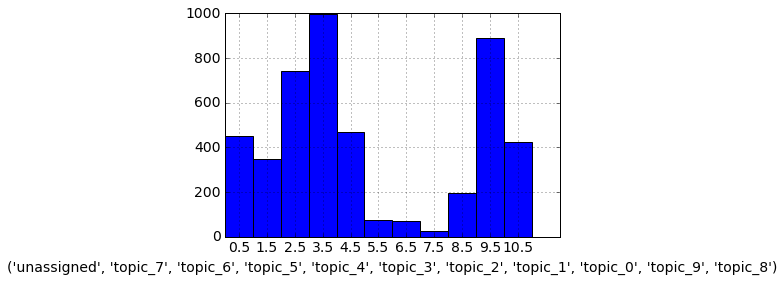

In [73]:
Scored_corpus['top_score'].hist(bins=60)

labels,values = zip(*Counter(Scored_corpus['top_topic'].tolist()).items())

topic_names = [label for label in labels if label != 'unassigned']

indexes = np.arange(len(labels))
width = 1
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5)
plt.xlabel(labels)
plt.xkcd()
plt.show()

You can see the breakdown of each document in the corpus based on the frequency of each topic (out of order because it's using the order of apperance in "top_topic")

In [74]:
Scored_corpus['top_score'].describe()

count     4678.0
unique     849.0
top          0.0
freq       442.0
Name: top_score, dtype: float64

In [75]:
Scored_corpus[topic_names].median()

topic_7    0.000000
topic_6    0.067163
topic_5    0.052918
topic_4    0.000000
topic_3    0.000000
topic_2    0.000000
topic_1    0.000000
topic_0    0.000000
topic_9    0.055281
topic_8    0.021471
dtype: float64

In [78]:
df.to_csv(r'C:\Users\Bill\Desktop\Tahzoo.com Redesign\GoogleAnalytics\Experiments\token_list.csv')

In [79]:
Scored_corpus.to_csv('C:\Users\Bill\Desktop\Tahzoo.com Redesign\GoogleAnalytics\Experiments\Scored_corpus.csv')

Building a solid them model involved running this over and over again. 
* Add terms to the Bad-words list. 
* Remove or add tokens. 
* Summarize the text into a single text token

Repeat this exorcise until the groups are meaningfull. 

In [81]:
import csv
w = csv.writer(open("C:\Users\Bill\Desktop\Tahzoo.com Redesign\GoogleAnalytics\Experiments\corpus.csv", "w"))
for key, val in corpus.items():
    w.writerow([key, val])
    